# Example Feature-Based Cluster Queries

In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import h5py
import math
import numpy as np

In [21]:
chrom = 'chr7'
bin_size = 100000

cluster_tsv_file = '../data/hg19/gm12878_triplets_chr7_100kb_pooled.tsv.gz'
cluster_h5_file = '../data/hg19/gm12878_triplets_chr7_100kb_pooled.h5'

chrom_sizes_file = '../data/hg19/hg19.chrom.sizes'

tads_arrowhead_bed_file = '../data/hg19/Rao_RepH_GM12878_Arrowhead.sorted.bed'
tads_arrowhead_sqlite_file = '../data/hg19/Rao_RepH_GM12878_Arrowhead.sorted.sqlite'

chromhmm_bed_file = '../data/hg19/wgEncodeBroadHmmGm12878HMM.bed.gz'
chromhmm_sqlite_file = '../data/hg19/wgEncodeBroadHmmGm12878HMM.sqlite'

subcompartments_bed_file = '../data/hg19/GSE63525_GM12878_subcompartments.bed.gz'
subcompartments_sqlite_file = '../data/hg19/GSE63525_GM12878_subcompartments.sqlite'

loop_extents_bed_file = '../data/hg19/GSE63525_GM12878_replicate_HiCCUPS_loop_extent_list.bed.gz'
loop_extents_sqlite_file = '../data/hg19/GSE63525_GM12878_replicate_HiCCUPS_loop_extent_list.sqlite'

In [22]:
from hgmc.utils import get_chrom_sizes

chrom_size = get_chrom_sizes(chrom_sizes_file).get(chrom)
num_bins = math.ceil(chrom_size / bin_size)

# Load Features

In [23]:
from hgmc.bed import sql_features
from utils import natural_sort

chromhmm_features = natural_sort(sql_features(chromhmm_sqlite_file))
chromhmm_features

['1_Active_Promoter',
 '2_Weak_Promoter',
 '3_Poised_Promoter',
 '4_Strong_Enhancer',
 '5_Strong_Enhancer',
 '6_Weak_Enhancer',
 '7_Weak_Enhancer',
 '8_Insulator',
 '9_Txn_Transition',
 '10_Txn_Elongation',
 '11_Weak_Txn',
 '12_Repressed',
 '13_Heterochrom/lo',
 '14_Repetitive/CNV',
 '15_Repetitive/CNV']

In [24]:
from hgmc.bed import sql_coverage

tad_coverage_100kb = sql_coverage(
    tads_arrowhead_sqlite_file,
    chrom=chrom,
    bin_size=bin_size,
    # At least 80% of the TAD needs to be in the bin to count
    count_at_feat_cov=0.8,
    rel_count_at_bin_cov=True,
    timeit=True
)
print(f'{tad_coverage_100kb.astype(bool).sum()} bins contain TADs with at most {tad_coverage_100kb.max()} TADs per bin')

active_promoter_coverage_100kb = sql_coverage(
    chromhmm_sqlite_file,
    chrom=chrom,
    bin_size=bin_size,
    features='1_Active_Promoter',
    # The entire promoter needs to be in the bin to count
    count_at_feat_cov=1.0,
    rel_count_at_bin_cov=True,
    timeit=True
)
print(f'{active_promoter_coverage_100kb.astype(bool).sum()} bins contain active promoters with at most {active_promoter_coverage_100kb.max()} active promoters per bin')

strong_enhancer_coverage_100kb = sql_coverage(
    chromhmm_sqlite_file,
    chrom=chrom,
    bin_size=bin_size,
    features=['4_Strong_Enhancer', '5_Strong_Enhancer'],
    # The entire enhancer needs to be in the bin to count
    count_at_feat_cov=1.0,
    rel_count_at_bin_cov=True,
    timeit=True
)
print(f'{strong_enhancer_coverage_100kb.astype(bool).sum()} bins contain enhancers with at most {strong_enhancer_coverage_100kb.max()} enhancers per bin')

a_compartment_coverage_100kb = sql_coverage(
    subcompartments_sqlite_file,
    chrom=chrom,
    bin_size=bin_size,
    features=['A1', 'A2'],
    # At least 80% of the bin need to be an A compartment to count
    count_at_bin_cov=0.8,
    rel_count_at_bin_cov=True,
    timeit=True
)
print(f'{a_compartment_coverage_100kb.astype(bool).sum()} bins are A compartment')

b_compartment_coverage_100kb = sql_coverage(
    subcompartments_sqlite_file,
    chrom=chrom,
    bin_size=bin_size,
    features=['B1', 'B2', 'B3', 'B4'],
    # At least 80% of the bin need to be an A compartment to count
    count_at_bin_cov=0.8,
    rel_count_at_bin_cov=True,
    timeit=True
)
print(f'{b_compartment_coverage_100kb.astype(bool).sum()} bins are B compartment')

loop_extent_coverage_100kb = sql_coverage(
    loop_extents_sqlite_file,
    chrom=chrom,
    bin_size=bin_size,
    # Only count if the entire loop extent is in the bin
    count_at_feat_cov=1.0,
    rel_count_at_bin_cov=True,
    timeit=True
)
print(f'{loop_extent_coverage_100kb.astype(bool).sum()} bins contain loops with at most {loop_extent_coverage_100kb.max()} loops per bin')

Took 0.054 sec
883 bins contain TADs with at most 3 TADs per bin
Took 3.931 sec
400 bins contain active promoters with at most 8 active promoters per bin
Took 4.632 sec
517 bins contain enhancers with at most 38 enhancers per bin
Took 0.082 sec
576 bins are A compartment
Took 0.084 sec
936 bins are B compartment
Took 0.097 sec
1107 bins contain loops with at most 7 loops per bin


In [25]:
all_features = [
    ('TADs', tad_coverage_100kb),
    ('Active Promoters', active_promoter_coverage_100kb),
    ('Strong Enhancers', strong_enhancer_coverage_100kb),
    ('A Compartments', a_compartment_coverage_100kb),
    ('B Compartments', b_compartment_coverage_100kb),
    ('Loops', loop_extent_coverage_100kb),
]

# Queries
## Find all triplets that span A-only compartments

In [47]:
from hgmc.clusters import clusters_to_bins, query_by_features, verify_queried_clusters
from hgmc.plots import plot_cluster_feature_distribution

with h5py.File(cluster_h5_file, 'r') as h5:
    #####
    query = [(a_compartment_coverage_100kb.astype(bool), 3)]
    #####
    
    a_cluster_ids = query_by_features(h5, query, verbose=True, verify=True, timeit=True)
    print(f'Found {ab_cluster_ids.size} clusters')

Mask creation took 0.54 sec
bin_to_cluster and cluster_to_bin extraction took 6.56 sec
Bin starts and ends extraction took 0.00 sec
Getting the unique cluster IDs took 1.14 sec
Total query took 8.24 sec
Verify results...
Mask generation took 0.4 sec
Cluster start/stop extraction took 2.5 sec
Vrange calculation took 0.3 sec
Cluster-to-bin extraction took 3.4 sec
Bin extraction took 0.0 sec
Total took 6.6 sec
Hooray! The clusters conform to the query.
Found 22481057 clusters


In [44]:
with h5py.File(cluster_h5_file, 'r') as h5:
    a_cluster_bins = clusters_to_bins(h5, a_cluster_ids)
    unique_a_cluster_bins = np.unique(a_cluster_bins[:, 1])
    print(f'Found {a_cluster_bins.shape[0]} bins ({unique_a_cluster_bins.size} bins)')

Found 9740508 bins (576 bins)


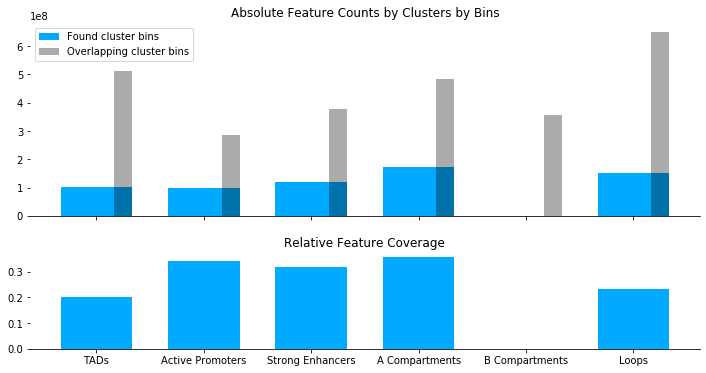

In [45]:
with h5py.File(cluster_h5_file, 'r') as h5:
    plot_cluster_feature_distribution(h5, a_cluster_bins, all_features, figsize=(12, 6))

## Find all triplets that span A&B compartments

In [33]:
with h5py.File(cluster_h5_file, 'r') as h5:
    #####
    query = [(a_compartment_coverage_100kb.astype(bool), 1), (b_compartment_coverage_100kb.astype(bool), 1)]
    #####
    
    ab_cluster_ids = query_by_features(h5, query, verbose=True, verify=True)
    print(f'Found {ab_cluster_ids.size} clusters')

Verify results...
Hooray! The clusters conform to the query.
Found 22481057 clusters


In [34]:
with h5py.File(cluster_h5_file, 'r') as h5:
    ab_cluster_bins = clusters_to_bins(h5, ab_cluster_ids)
    unique_ab_cluster_bins = np.unique(ab_cluster_bins[:, 1])
    print(f'Found {ab_cluster_bins.shape[0]} bins ({unique_ab_cluster_bins.size} bins)')

Found 67443171 bins (1562 bins)


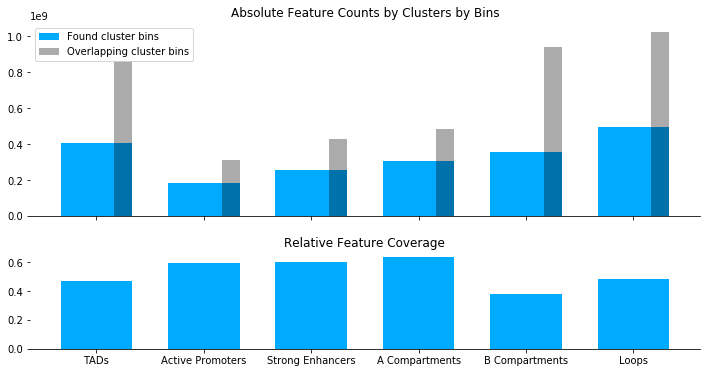

In [39]:
with h5py.File(cluster_h5_file, 'r') as h5:
    plot_cluster_feature_distribution(h5, ab_cluster_bins, all_features, figsize=(12, 6))

## Find all triplets that anchor in 3 peaks/loops

In [36]:
print(f'There are {loop_extent_coverage_100kb.astype(bool).sum()} bins with peaks')

with h5py.File(cluster_h5_file, 'r') as h5:
    #####
    query = [(loop_extent_coverage_100kb.astype(bool), 3)]
    #####
    
    loop_cluster_ids = query_by_features(h5, query, verbose=True, verify=True)
    print(f'Found {loop_cluster_ids.size} clusters')

There are 1107 bins with peaks
Verify results...
Hooray! The clusters conform to the query.
Found 15403326 clusters


In [37]:
with h5py.File(cluster_h5_file, 'r') as h5:
    loop_cluster_bins = clusters_to_bins(h5, loop_cluster_ids)
    unique_loop_cluster_bins = np.unique(loop_cluster_bins[:, 1])
    print(f'Found {loop_cluster_bins.shape[0]} bins ({unique_loop_cluster_bins.size} bins)')

Found 46209978 bins (1107 bins)


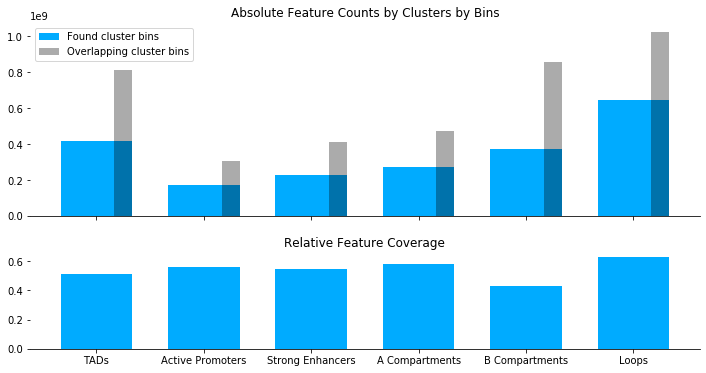

In [40]:
with h5py.File(cluster_h5_file, 'r') as h5:
    plot_cluster_feature_distribution(h5, loop_cluster_bins, all_features, figsize=(12,6))

## Find all triplets that anchor in 3 TADs

In [27]:
print(f'There are {tad_coverage_100kb.astype(bool).sum()} bins with TADs')

with h5py.File(cluster_h5_file, 'r') as h5:
    #####
    query = [(tad_coverage_100kb.astype(bool), 3)]
    #####
    
    tad_cluster_ids = query_by_features(h5, query, verbose=True, verify=True)
    print(f'Found {tad_cluster_ids.size} clusters')

There are 883 bins with TADs
Verify results...
Hooray! The clusters conform to the query.
Found 9052583 clusters


In [28]:
with h5py.File(cluster_h5_file, 'r') as h5:
    tad_cluster_bins = clusters_to_bins(h5, tad_cluster_ids)
    unique_tad_cluster_bins = np.unique(tad_cluster_bins[:, 1])
    print(f'Found {tad_cluster_bins.shape[0]} bins ({unique_tad_cluster_bins.size} bins)')

Found 27157749 bins (882 bins)


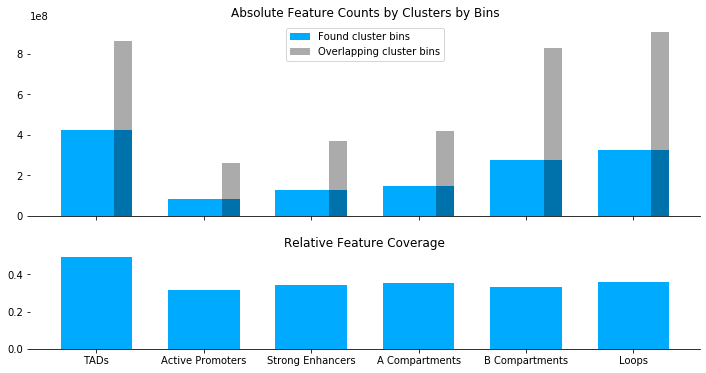

In [41]:
with h5py.File(cluster_h5_file, 'r') as h5:
    plot_cluster_feature_distribution(h5, tad_cluster_bins, all_features, figsize=(12,6))

## Find all triplets that anchor in at least 1 promoter and at least 2 active enhancers

In [30]:
with h5py.File(cluster_h5_file, 'r') as h5:
    query = [
        (active_promoter_coverage_100kb.astype(bool), 1),
        (strong_enhancer_coverage_100kb.astype(bool), 2)
    ]
    promoter_enhancer_cluster_ids = query_by_features(h5, query, verbose=True, verify=True)
    print(f'Found {promoter_enhancer_cluster_ids.size} clusters')

Verify results...
Hooray! The clusters conform to the query.
Found 1040286 clusters


In [31]:
with h5py.File(cluster_h5_file, 'r') as h5:
    promoter_enhancer_cluster_bins = clusters_to_bins(h5, promoter_enhancer_cluster_ids)
    unique_promoter_enhancer_cluster_bins = np.unique(promoter_enhancer_cluster_bins[:, 1])
    print(f'Found {promoter_enhancer_cluster_bins.shape[0]} bins ({unique_promoter_enhancer_cluster_bins.size} bins)')

Found 3120858 bins (617 bins)


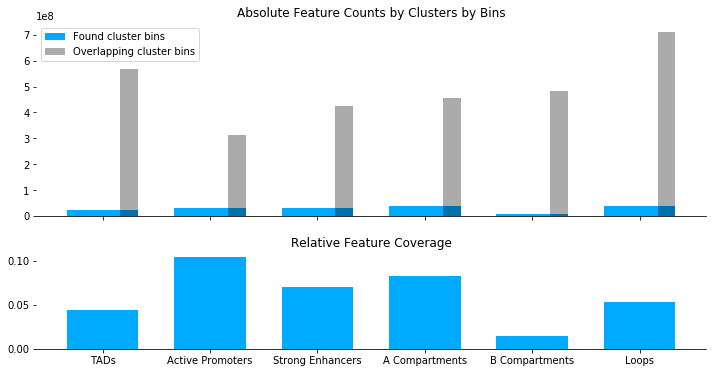

In [42]:
with h5py.File(cluster_h5_file, 'r') as h5:
    plot_cluster_feature_distribution(h5, promoter_enhancer_cluster_bins, all_features, figsize=(12,6))